<div style="text-align: right"> 
Universidad Nacional de Colombia <br>
Maestría en Ciencias - Estadística <br>
Data Science - Tópicos Avanzados de Estadística (2010661) <br>
Semestre 2021-1 
</div> 

<div style="text-align: right"> 
Estudiante: Diego Clemente Rojas Chingate   <br>
</div> 


# Tarea:

Use el conjunto de datos [airlines.zip](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) tomado de Kaggle.

Haga una análisis de sentimientos

1. Usando un modelo logístico  

2. Usando Naive Bayes  

3. Usando Support Vector Machine (SVM)  

4. Usando una red neuronal.  

5. Compare los resultados  

6. Repita el ejercicio anterior con la técnica que más le convenga, de acuerdo a la ejercicio anterior, con los datos [sentiment140 dataset..zip](https://www.kaggle.com/kazanova/sentiment140) que contiene 1.6 millones de datos. Consulte la documentación en Kaggle.

7. Haga un análisis de texto superficial completo con las palabras positivas y otro con las negativas por separado. Use fatstext y haga gráficas ilustrativas con TSNE. Apóyese en los cuadernos anexos

## Dataset Twitter US Airline Sentiment

De acuerdo al archivo **database.sqlite** se obtiene el siguiente esquema SQL:

![](https://drive.google.com/uc?export=view&id=1jQSPVMlSEWqMd6sUbib_1wwqNln47Oev)


## Exploración de los datos

Lectura de la información

In [ ]:
import sqlite3
import pandas as pd

sqlite_db = "./data/database.sqlite"

conn = sqlite3.connect(sqlite_db)
df = pd.read_sql_query("SELECT * FROM Tweets", conn)
conn.close()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14485 non-null  int64  
 1   airline_sentiment             14485 non-null  object 
 2   airline_sentiment_confidence  14485 non-null  float64
 3   negativereason                14485 non-null  object 
 4   negativereason_confidence     14485 non-null  object 
 5   airline                       14485 non-null  object 
 6   airline_sentiment_gold        14485 non-null  object 
 7   name                          14485 non-null  object 
 8   negativereason_gold           14485 non-null  object 
 9   retweet_count                 14485 non-null  int64  
 10  text                          14485 non-null  object 
 11  tweet_coord                   14485 non-null  object 
 12  tweet_created                 14485 non-null  object 
 13  t

In [ ]:
df

tweet_id  ...               user_timezone
0      567588278875213824  ...                      Sydney
1      567590027375702016  ...  Pacific Time (US & Canada)
2      567591480085463040  ...                            
3      567592368451248130  ...                Buenos Aires
4      567594449874587648  ...  Pacific Time (US & Canada)
...                   ...  ...                         ...
14480  570309308937842688  ...                       Quito
14481  570309340952993796  ...                      Hawaii
14482  570309345281486848  ...      Atlantic Time (Canada)
14483  570310144459972608  ...      Atlantic Time (Canada)
14484  570310600460525568  ...                            

[14485 rows x 15 columns]

In [ ]:
df.describe()

tweet_id  airline_sentiment_confidence  retweet_count
count  1.448500e+04                  14485.000000   14485.000000
mean   5.692072e+17                      0.899958       0.083397
std    7.756739e+14                      0.162961       0.749632
min    5.675883e+17                      0.335000       0.000000
25%    5.685515e+17                      0.692300       0.000000
50%    5.694398e+17                      1.000000       0.000000
75%    5.698811e+17                      1.000000       0.000000
max    5.703106e+17                      1.000000      44.000000

## Tweet más reciente

In [ ]:
df["tweet_created"] = pd.to_datetime(df['tweet_created'], infer_datetime_format=True)

In [ ]:
df[df["tweet_created"] == df["tweet_created"].max()]

tweet_id airline_sentiment  ...  tweet_location user_timezone
14484  570310600460525568          negative  ...                              

[1 rows x 15 columns]

## Tweet más viejo

In [ ]:
df[df["tweet_created"] == df["tweet_created"].min()]

tweet_id airline_sentiment  ...  tweet_location user_timezone
0  567588278875213824           neutral  ...             USA        Sydney

[1 rows x 15 columns]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Cantidad de Tweets por cada aerolínea

In [ ]:
df.groupby(["airline"]).count()["tweet_id"].index

Index(['American', 'Delta', 'Southwest', 'US Airways', 'United',
       'Virgin America'],
      dtype='object', name='airline')

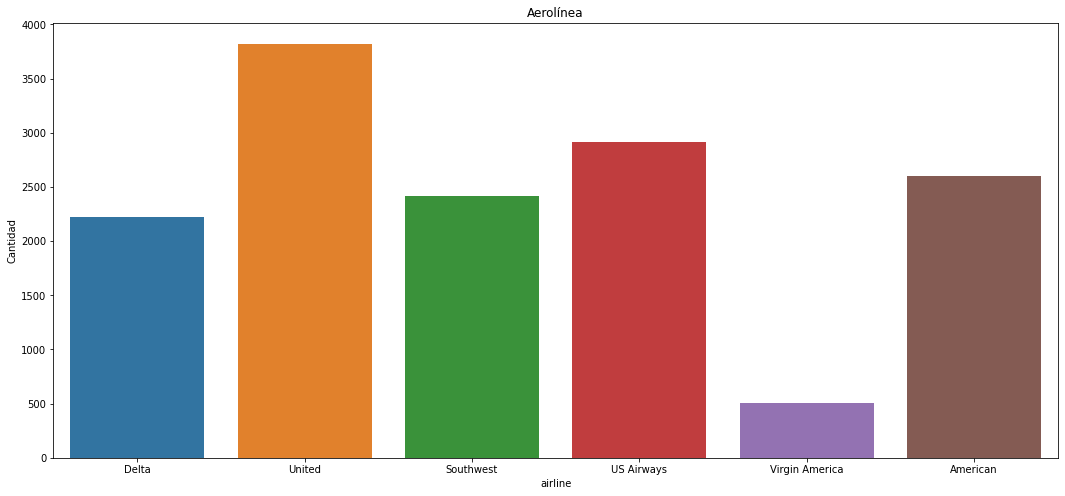

In [ ]:
plt.figure(figsize = (18, 8))
sns.countplot(data = df, x="airline")
plt.title('Aerolínea')
# plt.xlabel(' Falsa(0) / Real(1)')
plt.ylabel('Cantidad')
plt.show()

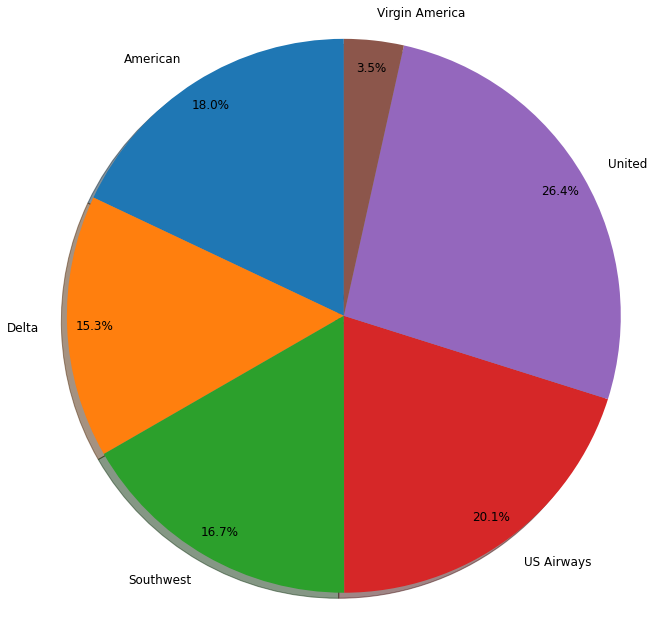

In [ ]:
fig1, ax1 = plt.subplots(figsize=(11, 11))
ax1.pie(list(df.groupby(["airline"]).count()["tweet_id"]), labels=list(df.groupby(["airline"]).count()["tweet_id"].index), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12},pctdistance=0.9)
ax1.axis('equal')  

plt.show()

## Cantidad de registros por lugar

In [ ]:
df.groupby(["user_timezone"]).count().sort_values(by=['tweet_id'], ascending=False)['tweet_id'].head(20)

user_timezone
                               4775
Eastern Time (US & Canada)     3720
Central Time (US & Canada)     1900
Pacific Time (US & Canada)     1196
Quito                           724
Atlantic Time (Canada)          494
Mountain Time (US & Canada)     358
Arizona                         226
London                          190
Sydney                          107
Alaska                          106
Hawaii                          104
Amsterdam                        74
America/Chicago                  37
America/New_York                 26
Indiana (East)                   25
Paris                            25
Brasilia                         23
Abu Dhabi                        23
Tehran                           17
Name: tweet_id, dtype: int64

## Registro de sentimientos

### Sobre el total

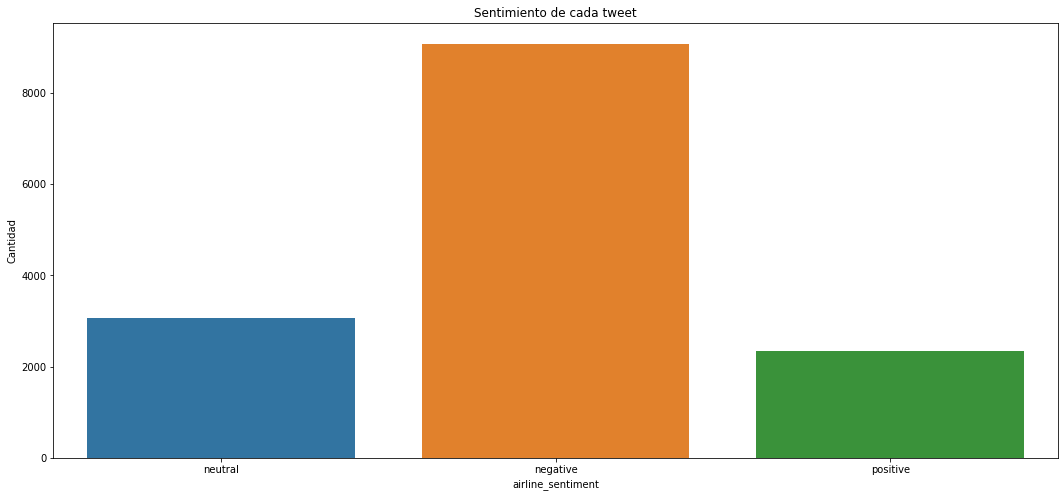

In [ ]:
plt.figure(figsize = (18, 8))
sns.countplot(data = df, x="airline_sentiment")
plt.title('Sentimiento de cada tweet')
# plt.xlabel(' Falsa(0) / Real(1)')
plt.ylabel('Cantidad')
plt.show()

### Por cada aerolínea

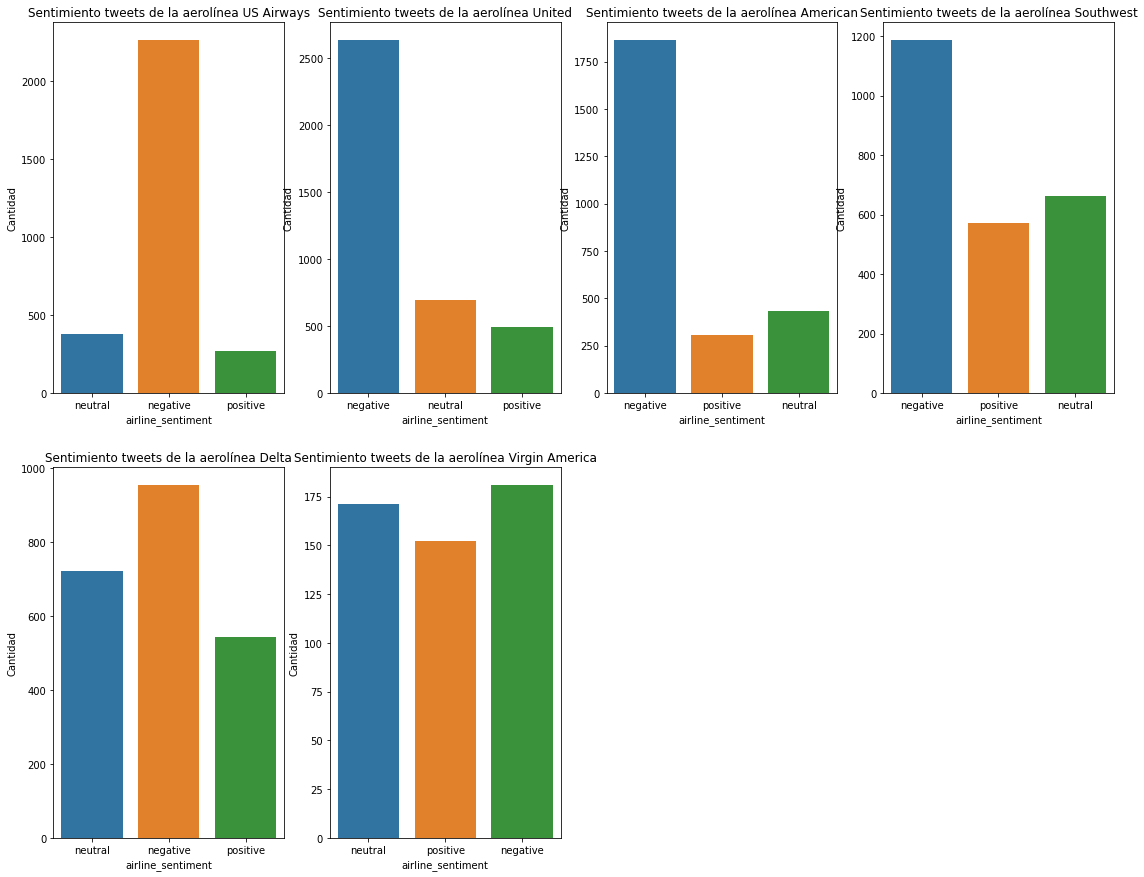

In [ ]:
def plot_sub_sentiment(airline):
    df_tmp = df[df['airline'] == airline]
    sns.countplot(data = df_tmp, x="airline_sentiment")
    plt.title('Sentimiento tweets de la aerolínea ' + airline)
    plt.ylabel('Cantidad')
plt.figure(1,figsize=(19, 15))
plt.subplot(241)
plot_sub_sentiment('US Airways')
plt.subplot(242)
plot_sub_sentiment('United')
plt.subplot(243)
plot_sub_sentiment('American')
plt.subplot(244)
plot_sub_sentiment('Southwest')
plt.subplot(245)
plot_sub_sentiment('Delta')
plt.subplot(246)
plot_sub_sentiment('Virgin America')

## Por razones

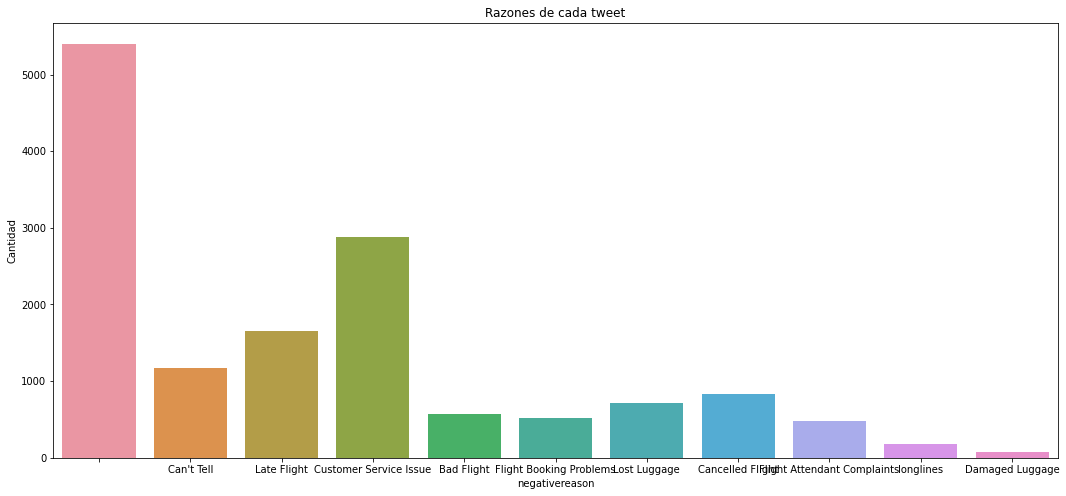

In [ ]:
plt.figure(figsize = (18, 8))
sns.countplot(data = df, x="negativereason")
plt.title('Razones de cada tweet')
# plt.xlabel(' Falsa(0) / Real(1)')
plt.ylabel('Cantidad')
plt.show()

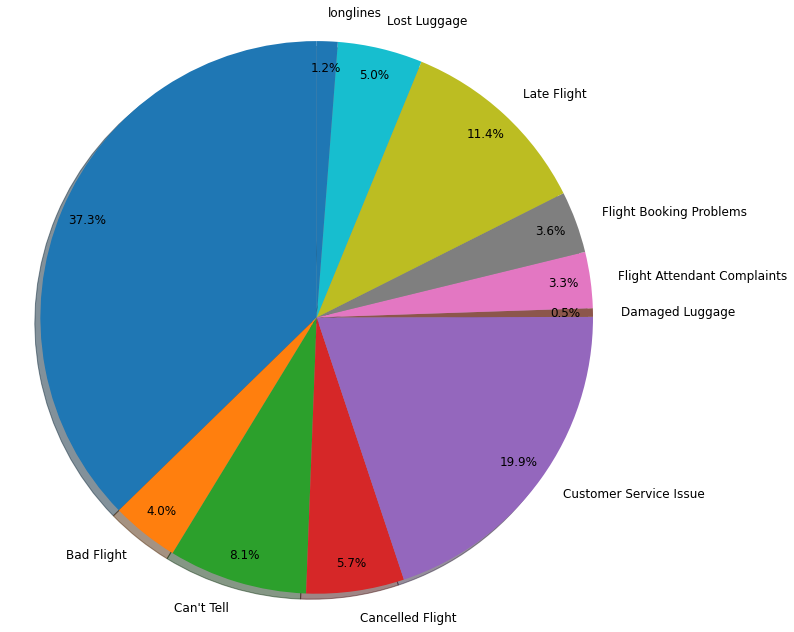

In [ ]:
fig1, ax1 = plt.subplots(figsize=(11, 11))
ax1.pie(list(df.groupby(["negativereason"]).count()["tweet_id"]), labels=list(df.groupby(["negativereason"]).count()["tweet_id"].index), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12},pctdistance=0.9)
ax1.axis('equal')  

plt.show()

## Nube de palabras

In [ ]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import nltk
import gensim

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(list(gensim.parsing.preprocessing.STOPWORDS))
stop_words = list(set(stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Sentimiento positivo

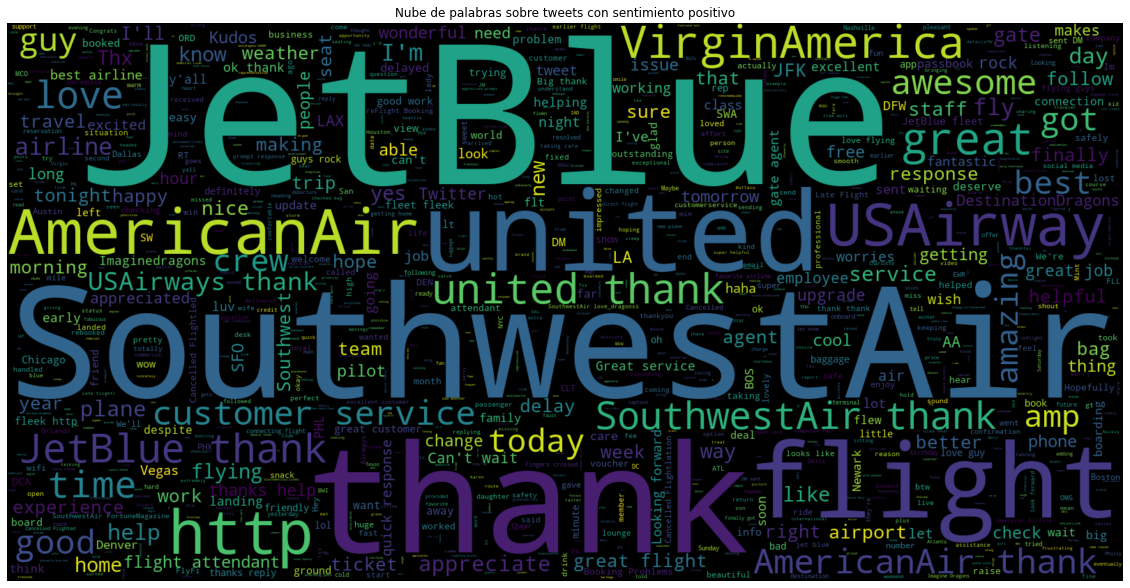

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.airline_sentiment == "positive"].text))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre tweets con sentimiento positivo')
plt.axis("off")
plt.show()

### Sentimiento negativo

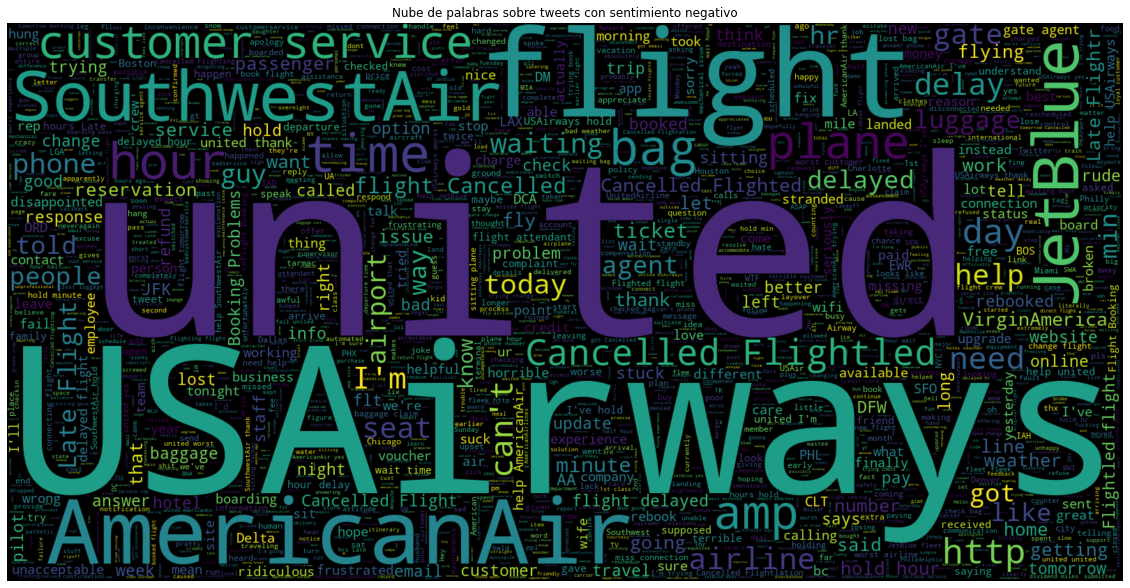

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.airline_sentiment == "negative"].text))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre tweets con sentimiento negativo')
plt.axis("off")
plt.show()

### Sentimiento neutral

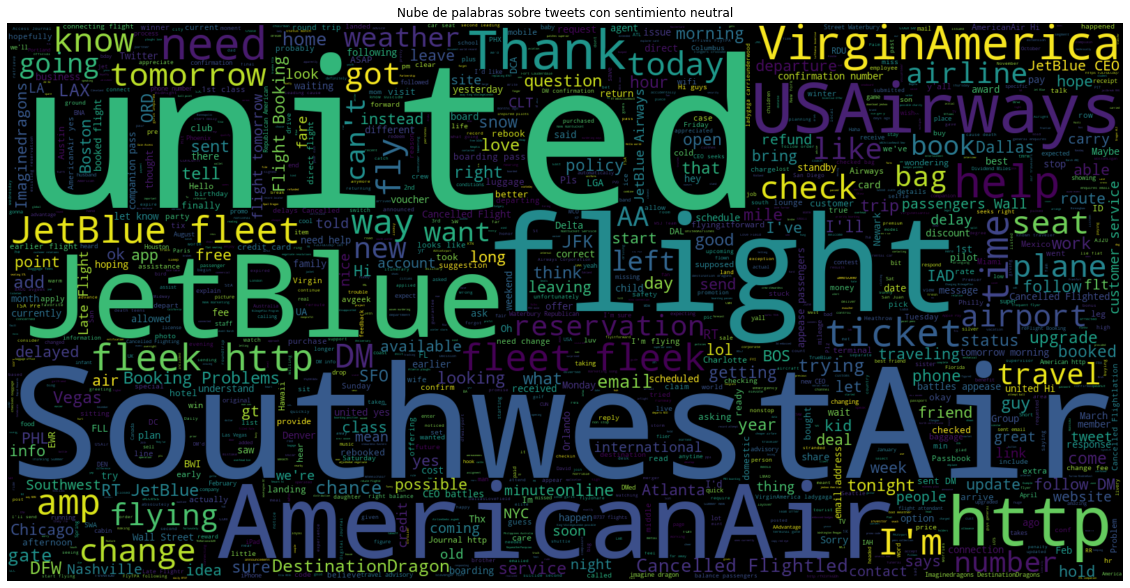

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.airline_sentiment == "neutral"].text))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre tweets con sentimiento neutral')
plt.axis("off")
plt.show()

# Preprocesamiento de los datos

## Eliminación de Stopwords

In [ ]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
import gensim

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(list(gensim.parsing.preprocessing.STOPWORDS))
stop_words = list(set(stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_raw(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        is_word = lambda x: re.search("^[0-9a-zA-Z]+$", token) is not None
        is_word = is_word or (lambda x: re.search('http\S+', token) is not None)
        is_word = is_word or (lambda x: re.search('@\w+', token) is not None)
        is_word = is_word or (lambda x: re.search('[^\w\s]', token) is not None)
        if is_word and (len(token) > 3 and token not in stop_words) or '.' in token or ',' in token:
            lemma_word = WordNetLemmatizer().lemmatize(token)
            result.append(lemma_word.lower())
            
    return " ".join(result)

In [ ]:
def preprocess_token(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        is_word = lambda x: re.search("^[0-9a-zA-Z]+$", token) is not None
        is_word = is_word or (lambda x: re.search('http\S+', token) is not None)
        is_word = is_word or (lambda x: re.search('@\w+', token) is not None)
        is_word = is_word or (lambda x: re.search('[^\w\s]', token) is not None)
        if is_word and (len(token) > 3 and token not in stop_words) or '.' in token or ',' in token:
            lemma_word = WordNetLemmatizer().lemmatize(token)
            result.append(lemma_word.lower())
            
    return result

In [ ]:
df['clean'] = df['text'].apply(preprocess_raw)
df['clean_token'] = df['text'].apply(preprocess_token)

In [ ]:
df['clean']

0        jetblue seek right balance passenger wall gree...
1                           jetblue getting nerve nothappy
2        united waited line hour passenger left wanting...
3        united gate time given seat closed flight know...
4        southwestair cool bag longer dont baggage blue...
                               ...                        
14480                     jetblue hope hate change airline
14481                         usairways possible following
14482    jetblue yesterday wheelsup jetbluesofly http xkiy
14483                      usairways agent available speak
14484    usairways better time flight friday need chang...
Name: clean, Length: 14485, dtype: object

In [ ]:
df['clean_token']

0        [jetblue, seek, right, balance, passenger, wal...
1                      [jetblue, getting, nerve, nothappy]
2        [united, waited, line, hour, passenger, left, ...
3        [united, gate, time, given, seat, closed, flig...
4        [southwestair, cool, bag, longer, dont, baggag...
                               ...                        
14480               [jetblue, hope, hate, change, airline]
14481                     [usairways, possible, following]
14482    [jetblue, yesterday, wheelsup, jetbluesofly, h...
14483                 [usairways, agent, available, speak]
14484    [usairways, better, time, flight, friday, need...
Name: clean_token, Length: 14485, dtype: object

In [ ]:
list_of_words = []
unique_words = set()
max_len_tweet = 0
for tweet_list in df.clean_token:
    max_len_tweet = max(max_len_tweet, len(tweet_list))
    for tweet in tweet_list:
        list_of_words.append(tweet)
        unique_words.add(tweet)
        
total_words = len(list_of_words)  # total words
unique_words = len(unique_words)   # total unique words
print("Total words:" + str(total_words) + " unique_words:" + str(unique_words) + " max_tweet_length=" + str(max_len_tweet))

Total words:110784 unique_words:10608 max_tweet_length=18


## Modelo FastText y gráfica TSNE

In [ ]:
from gensim.models import FastText

ft_model = FastText(df.clean, size=100, 
                          window=30, min_count=1,
                          sample=1e-3, iter=50)

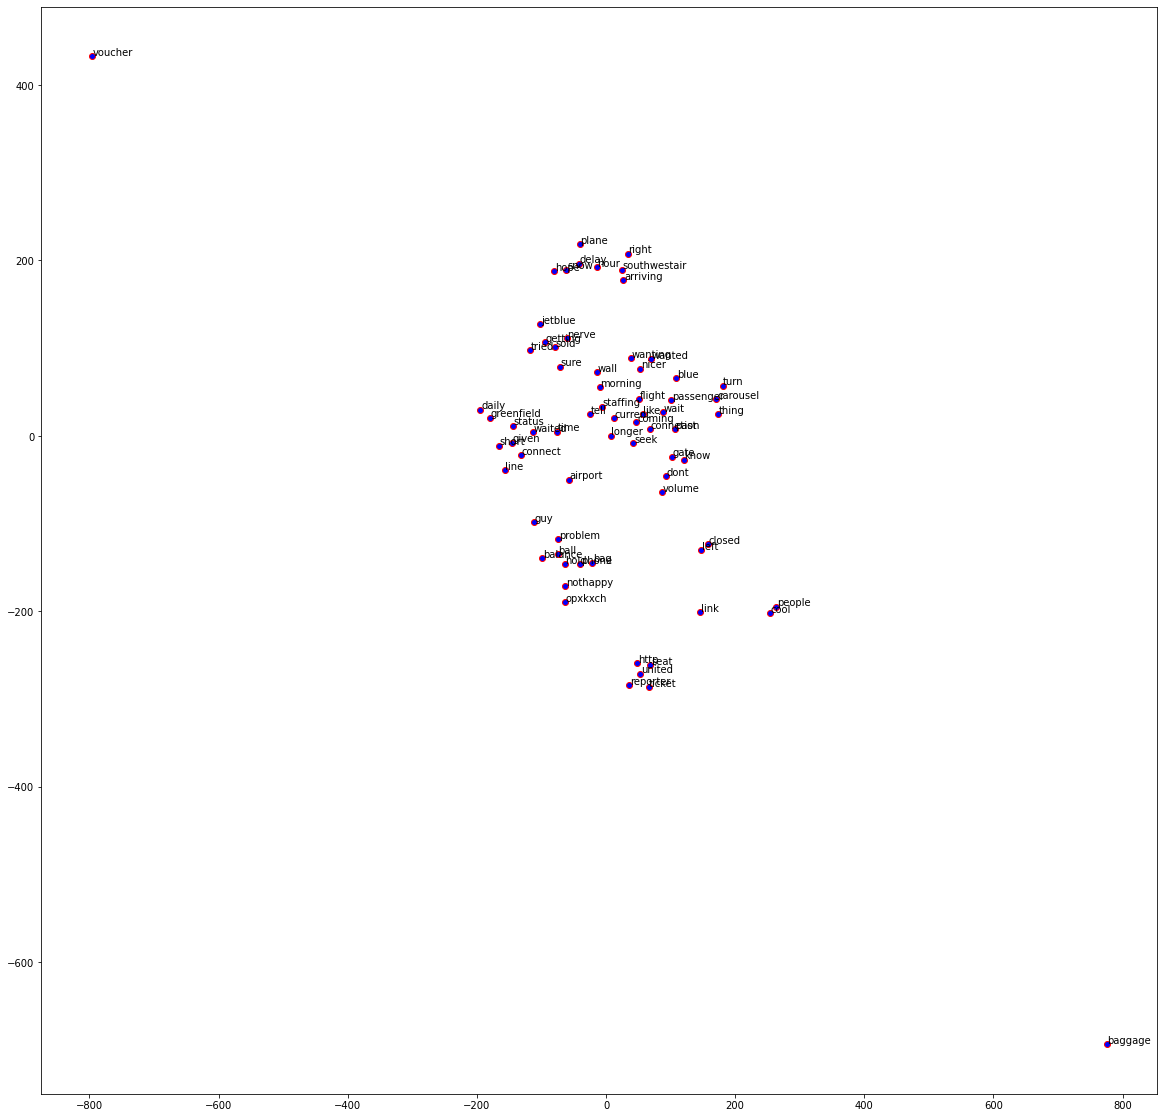

In [ ]:
from sklearn.manifold import TSNE
import numpy
import matplotlib.pyplot as plt

fts = ft_model.wv[ft_model.wv.vocab]

tsne = TSNE(n_components=2, random_state=100, n_iter=10000, perplexity=2)
numpy.set_printoptions(suppress=True)
T = tsne.fit_transform(fts[470:540])
labels = list(ft_model.wv.vocab.keys())

plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='blue', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Vectorización

In [ ]:
from sklearn.model_selection import train_test_split

df["sentiment"] = df["airline_sentiment"].map({'negative':0, 'neutral':1, 'positive':2}).astype(int)

train, test = train_test_split(df, test_size=0.2, random_state=1)
X_train = train['clean'].values
X_test = test['clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [ ]:
from nltk.tokenize import TweetTokenizer

def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)


en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

In [ ]:
train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)

In [ ]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len_tweet = 20
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_size = len(tokenizer.word_index) + 1
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_train_padded = pad_sequences(x_train_seq, maxlen = max_len_tweet, padding = 'post')
x_test_padded = pad_sequences(x_test_seq, maxlen = max_len_tweet, truncating = 'post')

## Análisis de sentimiento

### 1. Modelo de regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.01, max_iter=5000)
LR.fit(train_features,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred_lr = LR.predict(test_features)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_lr = accuracy_score(list(y_test), pred_lr)
print("Model Accuracy : ", accuracy_lr)

Model Accuracy :  0.7217811529168104


### 2. Modelo Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(train_features, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
pred_clf = clf.predict(test_features)

In [ ]:
accuracy_clf = accuracy_score(list(y_test), pred_clf)
print("Model Accuracy : ", accuracy_clf)

Model Accuracy :  0.6234035208836728


### 3. Support vector machine

In [ ]:
from sklearn.svm import SVC

# svm = SVC()
svm = SVC(kernel="rbf", C=0.025, probability=True)
svm.fit(train_features, y_train)

SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
pred_svm = svm.predict(test_features)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_svm = accuracy_score(list(y_test), pred_svm)
print("Model Accuracy : ", accuracy_svm)

Model Accuracy :  0.6372109078356921


## 4. Red Neuronal

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Embedding
from tensorflow.keras.utils import to_categorical

model=Sequential()
model.add(Embedding(word_size,input_length=max_len_tweet, output_dim = 64))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
model.fit(x_train_padded, to_categorical(y_train, num_classes=3, dtype='int32'), epochs = 50, batch_size=128)

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_107 (Embedding)    (None, 20, 64)            597248    
_________________________________________________________________
dense_338 (Dense)            (None, 20, 128)           8320      
_________________________________________________________________
dropout_232 (Dropout)        (None, 20, 128)           0         
_________________________________________________________________
dense_339 (Dense)            (None, 20, 64)            8256      
_________________________________________________________________
dropout_233 (Dropout)        (None, 20, 64)            0         
_________________________________________________________________
dense_340 (Dense)            (None, 20, 32)            2080      
_________________________________________________________________
dropout_234 (Dropout)        (None, 20, 32)         

In [ ]:
pred_model = [numpy.argmax(pred) for pred in model.predict(x_test_padded)]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_model = accuracy_score(y_test, pred_model)
print("Model Accuracy : ", accuracy_model)

Model Accuracy :  0.6830203658957542


## 5. Compare resultados

Los resultados obtenidos son los siguientes:  

| Método      | Accuracy |
| ----------- | ----------- |
|  Modelo logístico      | 0.7218     |
| SVM   | 0.6372        |
|Naive Bayes   | 0.6372        |
| Red Neuronal   | 0.6830       |

Por lo cual se toma el **modelo de regresión logística** , como la mejor opción

## 6. Repetir los pasos anteriores para el dataset **Sentiment140**

In [1]:
import pandas as pd

df = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names=["target", "ids", "date", "flag", "user", "text"])
df.head()

target  ...                                               text
0       0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  ...  is upset that he can't update his Facebook by ...
2       0  ...  @Kenichan I dived many times for the ball. Man...
3       0  ...    my whole body feels itchy and like its on fire 
4       0  ...  @nationwideclass no, it's not behaving at all....

[5 rows x 6 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df

target  ...                                               text
0             0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1             0  ...  is upset that he can't update his Facebook by ...
2             0  ...  @Kenichan I dived many times for the ball. Man...
3             0  ...    my whole body feels itchy and like its on fire 
4             0  ...  @nationwideclass no, it's not behaving at all....
...         ...  ...                                                ...
1599995       4  ...  Just woke up. Having no school is the best fee...
1599996       4  ...  TheWDB.com - Very cool to hear old Walt interv...
1599997       4  ...  Are you ready for your MoJo Makeover? Ask me f...
1599998       4  ...  Happy 38th Birthday to my boo of alll time!!! ...
1599999       4  ...  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 6 columns]

In [ ]:
df.describe()

target           ids
count  1.600000e+06  1.600000e+06
mean   2.000000e+00  1.998818e+09
std    2.000001e+00  1.935761e+08
min    0.000000e+00  1.467810e+09
25%    0.000000e+00  1.956916e+09
50%    2.000000e+00  2.002102e+09
75%    4.000000e+00  2.177059e+09
max    4.000000e+00  2.329206e+09

## Tweet más reciente

In [ ]:
df["date"] = pd.to_datetime(df['date'], infer_datetime_format=True)

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [ ]:
df[df["date"] == df["date"].max()]

target  ...                                               text
799999       0  ...  has to resit exams over summer...  wishes he w...

[1 rows x 6 columns]

## Tweet más viejo

In [ ]:
df[df["date"] == df["date"].min()]

target  ...                                               text
0       0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...

[1 rows x 6 columns]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de los datos

## Eliminación de Stopwords

In [2]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
import gensim

nltk.download('wordnet')
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(list(gensim.parsing.preprocessing.STOPWORDS))
stop_words = list(set(stop_words))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def preprocess_raw(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        is_word = lambda x: re.search("^[0-9a-zA-Z]+$", token) is not None
        is_word = is_word or (lambda x: re.search('http\S+', token) is not None)
        is_word = is_word or (lambda x: re.search('@\w+', token) is not None)
        is_word = is_word or (lambda x: re.search('[^\w\s]', token) is not None)
        if is_word and (len(token) > 3 and token not in stop_words) or '.' in token or ',' in token:
            lemma_word = WordNetLemmatizer().lemmatize(token)
            result.append(lemma_word.lower())
            
    return " ".join(result)

In [4]:
def preprocess_token(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        is_word = lambda x: re.search("^[0-9a-zA-Z]+$", token) is not None
        is_word = is_word or (lambda x: re.search('http\S+', token) is not None)
        is_word = is_word or (lambda x: re.search('@\w+', token) is not None)
        is_word = is_word or (lambda x: re.search('[^\w\s]', token) is not None)
        if is_word and (len(token) > 3 and token not in stop_words) or '.' in token or ',' in token:
            lemma_word = WordNetLemmatizer().lemmatize(token)
            result.append(lemma_word.lower())
            
    return result

In [5]:
df['clean'] = df['text'].apply(preprocess_raw)
df['clean_token'] = df['text'].apply(preprocess_token)

In [ ]:
df['clean']

0          switchfoot http twitpic awww bummer shoulda da...
1          upset update facebook texting result school to...
2           kenichan dived time ball managed save rest bound
3                                       body feel itchy like
4                                   nationwideclass behaving
                                 ...                        
1599995                             woke school best feeling
1599996       thewdb cool hear walt interview http blip bmta
1599997                           ready mojo makeover detail
1599998          happy birthday alll time tupac amaru shakur
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: clean, Length: 1600000, dtype: object

In [ ]:
df['clean_token']

0          [switchfoot, http, twitpic, awww, bummer, shou...
1          [upset, update, facebook, texting, result, sch...
2          [kenichan, dived, time, ball, managed, save, r...
3                                  [body, feel, itchy, like]
4                                [nationwideclass, behaving]
                                 ...                        
1599995                        [woke, school, best, feeling]
1599996    [thewdb, cool, hear, walt, interview, http, bl...
1599997                      [ready, mojo, makeover, detail]
1599998    [happy, birthday, alll, time, tupac, amaru, sh...
1599999    [happy, charitytuesday, thenspcc, sparkscharit...
Name: clean_token, Length: 1600000, dtype: object

In [ ]:
list_of_words = []
unique_words = set()
max_len_tweet = 0
for tweet_list in df.clean_token:
    max_len_tweet = max(max_len_tweet, len(tweet_list))
    for tweet in tweet_list:
        list_of_words.append(tweet)
        unique_words.add(tweet)
        
total_words = len(list_of_words)  # total words
unique_words = len(unique_words)   # total unique words
print("Total words:" + str(total_words) + " unique_words:" + str(unique_words) + " max_tweet_length=" + str(max_len_tweet))

Total words:8926808 unique_words:579251 max_tweet_length=30


## Nube de palabras

In [ ]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import gensim

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(list(gensim.parsing.preprocessing.STOPWORDS))
stop_words = list(set(stop_words))

## Sentimiento positivo

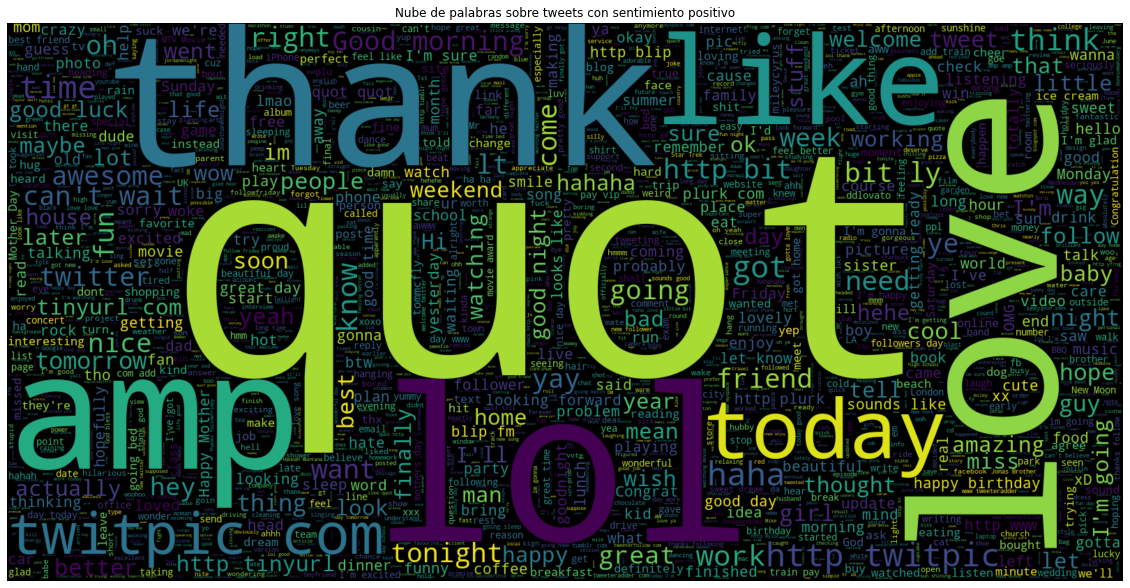

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 4].text))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre tweets con sentimiento positivo')
plt.axis("off")
plt.show()

## Sentimiento negativo

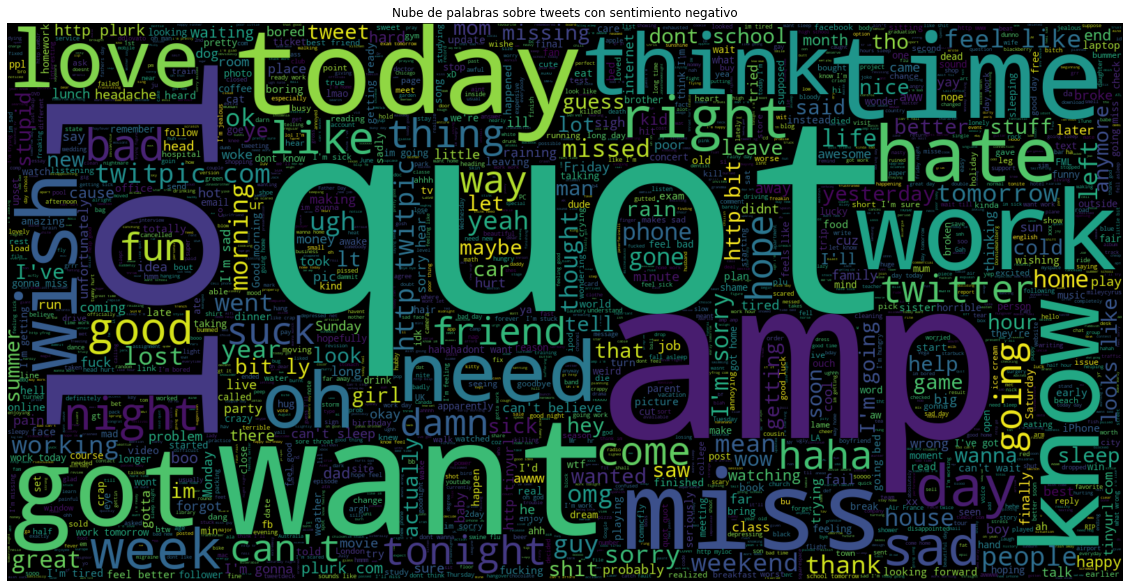

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].text))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre tweets con sentimiento negativo')
plt.axis("off")
plt.show()

## Modelo FastText y gráfica TSNE

In [6]:
from gensim.models import FastText

ft_model = FastText(df.clean_token, size=100, 
                          window=30, min_count=1,
                          sample=1e-3, iter=50)

In [ ]:
ft_model1 = ft_model

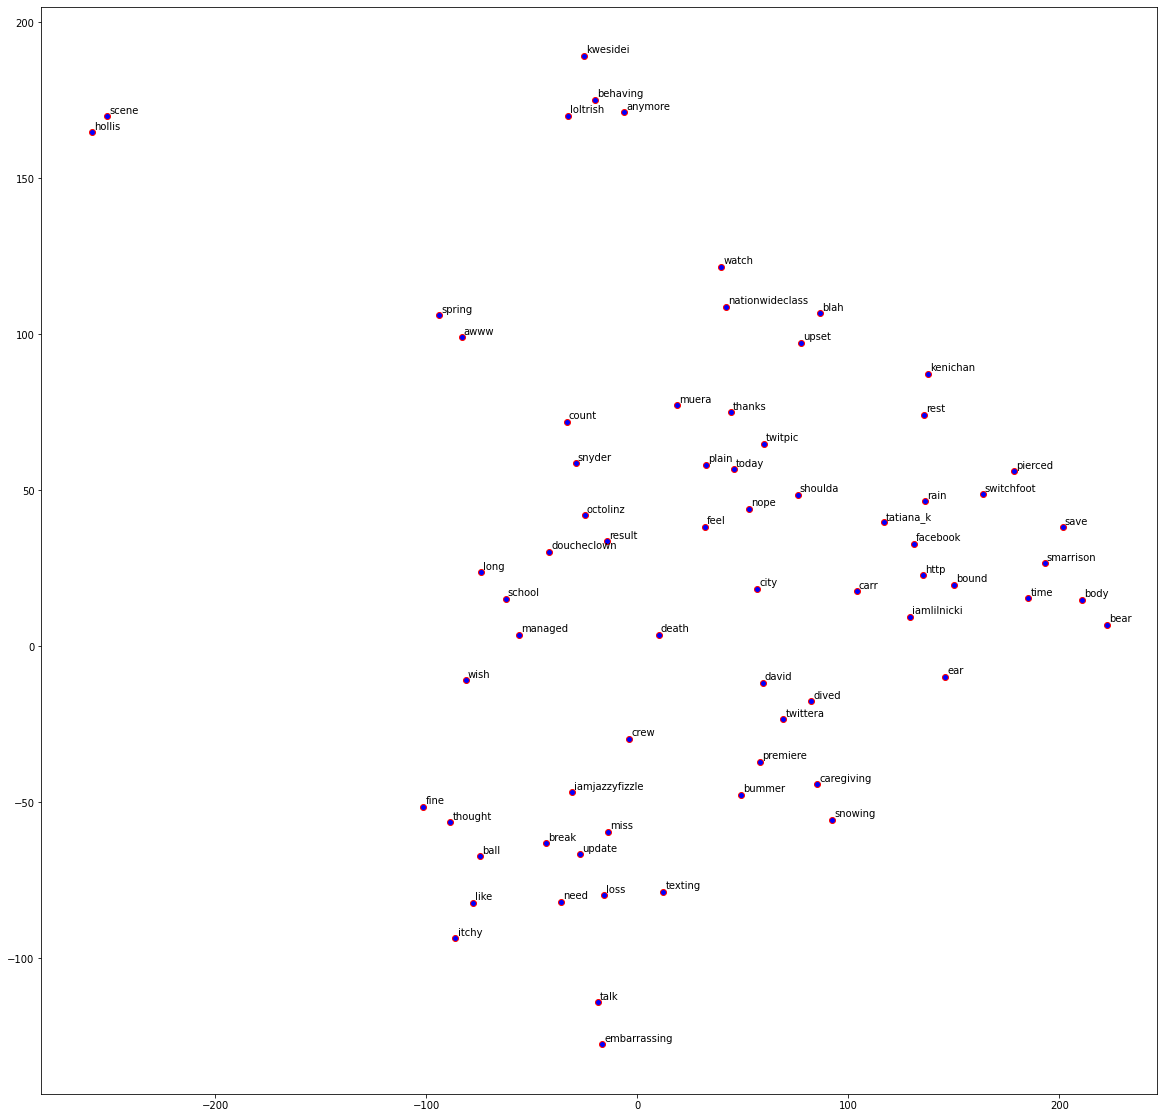

In [7]:
from sklearn.manifold import TSNE
import numpy
import matplotlib.pyplot as plt

fts = ft_model.wv[ft_model.wv.vocab]

tsne = TSNE(n_components=2, random_state=100, n_iter=10000, perplexity=2)
numpy.set_printoptions(suppress=True)
T = tsne.fit_transform(fts[470:540])
labels = list(ft_model.wv.vocab.keys())

plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='blue', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Vectorización

In [19]:
from sklearn.model_selection import train_test_split

df["sentiment"] = df["target"].map({0:0, 4:1}).astype(int)

train, test = train_test_split(df, test_size=0.2, random_state=1)
X_train = train['clean'].values
X_test = test['clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [20]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer

def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)


en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

In [21]:
train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)

## Análisis de sentimiento

### 1. Modelo de regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=1, max_iter=5000)
LR.fit(train_features,y_train)

In [ ]:
pred_lr = LR.predict(test_features)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_lr = accuracy_score(list(y_test), pred_lr)
print("Model Accuracy : ", accuracy_lr)